This was a final project I completed for my Empirical Applications of Economic Theory Course in grad school. I used the BLP method of demand curve estimation to predict the welfare impacts of mergers between different types of TV services. In this fake setup, we generated data for 600 markets (aka cities) which each had 4 goods to choose between (2 satelite TV and 2 wired TV). This data generation is done in parts 1-3. I used OLS to estimate demand in parts 4-6, but prices are endogenous to demand so they are not accurate models. In parts 7-9 I used the BLP model to correctly estimate demand. Finally, in parts 10-14, I analyzed the potential mergers between TV service companies.

In [71]:
import numpy as np
from scipy import optimize
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
import pyblp
import tabulate
pyblp.options.digits = 2

np.random.seed(1111)

# Given Parameters
T = 600 # number of markets
J = 4 # number of products 
alpha = -2
gamma_0 = 1/2
gamma_1 = 1/4
betas = np.array([1, 4, 4, -2]) # [beta_1, beta_2, beta_3, alpha]

# Chosen Parameters
N_draws = 500


Part 1 - Generate X, W, Omega and Xi

In [72]:
X = abs(np.random.normal(0, 1, (T, J)))
W = abs(np.random.normal(0, 1, (T, J)))

cov_array = np.array([[1,0.25],[0.25, 1]])
L = np.linalg.cholesky(cov_array)
Xi = np.empty([T,J])
Omega = np.empty([T,J])

for t in range(T):
    for j in range (J):
        z = np.random.normal(0, 1, (2,1))
        y = np.dot(L, z)
        Xi[t,j] = np.squeeze(y[0])
        Omega[t,j] = np.squeeze(y[1])

SAT = np.column_stack([np.ones(T), np.ones(T), np.zeros(T), np.zeros(T)]) # (TxJ) each row is [1,1,0,0]
WIR = np.column_stack([np.zeros(T), np.zeros(T), np.ones(T), np.ones(T)]) # (TxJ) each row is [0,0,1,1]
v_vec = np.random.normal(0, 1, (N_draws, 2)) # (N_draws x 2) for beta_2 and beta_3

Part 2 - Calculate Equilibrium Prices

In [73]:
# returns (Jx1) shares in a market t
def shares(p, xi, sat, wir, x, v):
    denominator = 1
    numerator = np.zeros(J)
    for j_index in range(J):
        share_j = np.exp(np.dot([x[j_index], sat[j_index], wir[j_index], p[j_index]], betas) +
                     sat[j_index] * v[0] + wir[j_index] * v[1] +
                     xi[j_index])
        numerator[j_index] = share_j
        denominator += share_j
    return numerator / denominator

# returns (Jx1) shares for market t (averaged over all draws)
def estimated_shares(p, t):
    sum_shares = np.zeros(J)
    for r in range(N_draws):
        sum_shares += shares(p, Xi[t], SAT[t], WIR[t], X[t], v_vec[r])
    return sum_shares / N_draws

# returns J marginal costs for each product in market t
def mc(t):
    return np.exp(gamma_0 + W[t] * gamma_1 + (Omega[t] / 8))

# returns (J x 1) vector of derivatives
def dsj_dpj(shares_j, coeff):
    return coeff * shares_j * (1 - shares_j)

# returns (J x 1) vector of FOC's
def foc_func(p, t, p_guess):
    shares_j = estimated_shares(p_guess, t)
    return (p - mc(t)) * dsj_dpj(shares_j, alpha) + shares_j

# Find equilibrium prices for all T markets (should take about 30 seconds to run). If nothing prints out, then all prices converged sucessfully 
equilib_prices = np.zeros([T,J]) 
for t in range(T):
    init_prices = np.random.uniform(0,1,(J))
    prices_t = optimize.root(foc_func, init_prices, args=(t, init_prices))
    equilib_prices[t] = prices_t.x # x is (1x4) vector of prices
    if  prices_t.success == False:
        print(equilib_prices[t])
        break

Part 3 - Calculate "Observed" Shares

In [27]:
observed_shares = np.empty((T,J))
for t in range(T):
    observed_shares[t] = estimated_shares(equilib_prices[t], t)

Part 4 - Estimate Demand with OLS

In [28]:
log_odds = np.empty((T,J))
for t in range(T):
   sum_inside_shares =  np.sum(observed_shares[t])
   outside_option_share = np.maximum(1 - sum_inside_shares, np.finfo(float).eps) # use maximum so you don't divide by 0
   log_odds[t] = np.log(observed_shares[t] / outside_option_share)

y = log_odds.flatten()
indep_vars = pd.DataFrame({
    'prices': equilib_prices.flatten(),
    'sat': SAT.flatten(),
    'wired': WIR.flatten(),
    'x': X.flatten(),
})

ols_model = sm.OLS(y, indep_vars).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     1752.
Date:                Sun, 14 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:15:59   Log-Likelihood:                -3001.4
No. Observations:                2400   AIC:                             6011.
Df Residuals:                    2396   BIC:                             6034.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
prices        -1.4865      0.021    -72.215      0.0

Part 5  - Estimate Demand with 2SLS

The R^2 term is lower in the 2SLS estimate, dropping from 0.687 to 0.590. The coefficient on prices decreased in magnitude from -1.49 to -1.16, which makes sense considering the endogeneity in OLS would bias the price coefficent away from zero. 

In [29]:
instrument_vars = pd.DataFrame({
    'sat': SAT.flatten(),
    'wired': WIR.flatten(),
    'x': X.flatten(),
    'w': W.flatten()
})

exog_vars = pd.DataFrame({
    'prices': equilib_prices.flatten(),
    'sat': SAT.flatten(),
    'wired': WIR.flatten(),
})

iv_model = IV2SLS(endog = y, exog = exog_vars, instrument = instrument_vars).fit()
print(iv_model.summary())

                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                       0.590
Model:                         IV2SLS   Adj. R-squared:                  0.590
Method:                     Two Stage   F-statistic:                       nan
                        Least Squares   Prob (F-statistic):                nan
Date:                Sun, 14 Apr 2024                                         
Time:                        19:15:59                                         
No. Observations:                2400                                         
Df Residuals:                    2397                                         
Df Model:                           2                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
prices        -1.1564      0.048    -23.931      0.0

Part 6 - Diversion Ratios

The first two diversion tables calculate the average of all the diversion ratios across markets. The first table uses estimated values, and the second uses true shares (genererated from the data in part 1 and 2). These average tables are very similar when just looking at the colors, so relative diversion seems simalar across specifications. However, the magnitudes for the diversion ratios are higher for the estimated table. The tables below compare estimated vs true values for a singular market. The estimated diversions are again higher than the true matrix. This time both the color and scale differ. 

Text(0.5, 1.0, 'True diversion matrix for market 200')

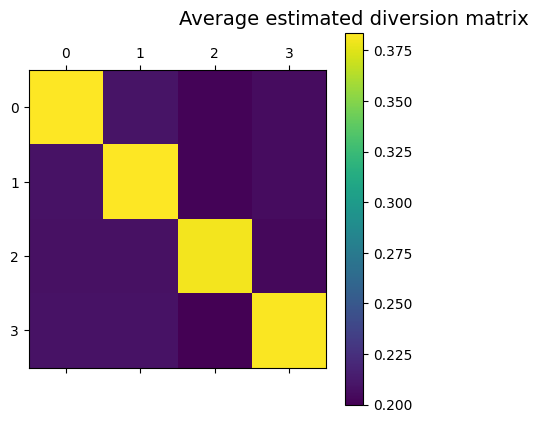

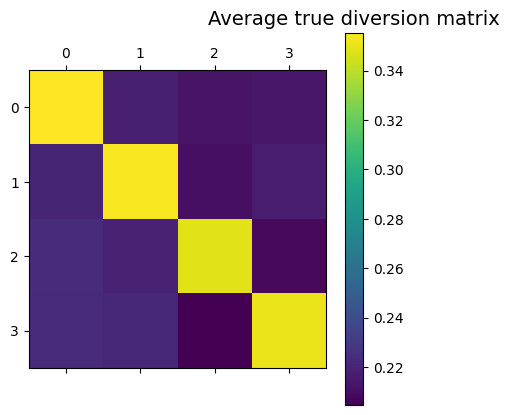

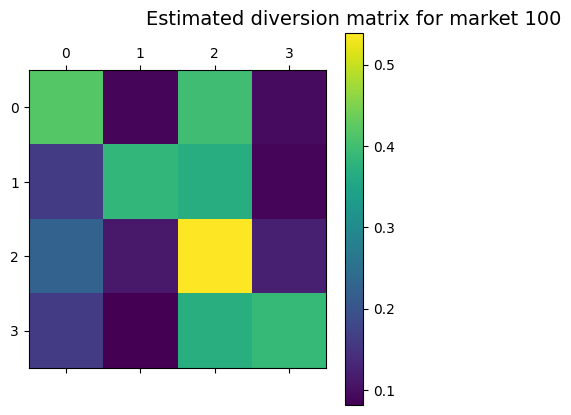

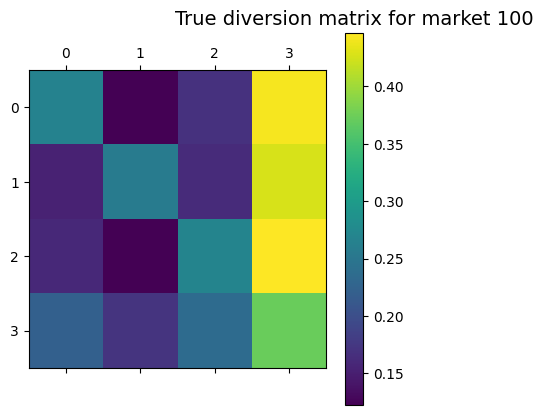

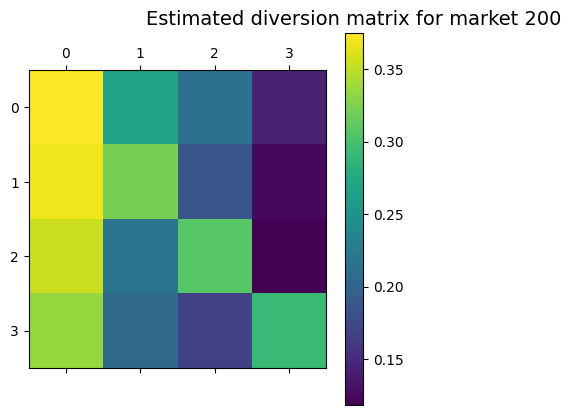

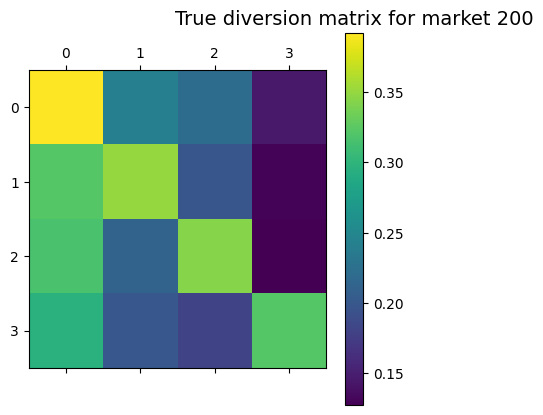

In [30]:
def calc_div_matrix(all_shares, coeff):
    div_matrix = np.empty((T,J,J))
    for t in range(T):
        denominator_derivs = dsj_dpj(all_shares[t], coeff) # (4x1) array
        outside_share = 1 - np.sum(all_shares[t])
        for j in range(J): # row of diversion matrix in market t
            for k in range(J): # col of diversion matrix in market t
                numerator_share = all_shares[t, k] if k != j else outside_share
                numerator_derivative = - coeff * numerator_share * all_shares[t, j]
                div_matrix[t,j,k] = - numerator_derivative / denominator_derivs[j]
    return div_matrix

est_alpha = iv_model.params['prices']
est_log_odds = np.exp(np.array(iv_model.fittedvalues)).reshape(T,J)
est_market_sum = np.sum(est_log_odds, axis = 1).reshape(T,1) + 1
est_shares = est_log_odds / est_market_sum

true_div_matrix = calc_div_matrix(observed_shares, alpha)
estimated_div_matrix = calc_div_matrix(est_shares, est_alpha)

avg_est_div_ratios = estimated_div_matrix.mean(axis= 0)
avg_true_div_matrix = true_div_matrix.mean(axis= 0)

plt1 = plt.colorbar(plt.matshow(avg_est_div_ratios))
plt1.ax.set_title('Average estimated diversion matrix',fontsize=14)
plt2 = plt.colorbar(plt.matshow(avg_true_div_matrix))
plt2.ax.set_title('Average true diversion matrix',fontsize=14)

plt3 = plt.colorbar(plt.matshow(estimated_div_matrix[100]))
plt3.ax.set_title('Estimated diversion matrix for market 100',fontsize=14)
plt4 = plt.colorbar(plt.matshow(true_div_matrix[100]))
plt4.ax.set_title('True diversion matrix for market 100',fontsize=14)

plt5 = plt.colorbar(plt.matshow(estimated_div_matrix[200]))
plt5.ax.set_title('Estimated diversion matrix for market 200',fontsize=14)
plt6 = plt.colorbar(plt.matshow(true_div_matrix[200]))
plt6.ax.set_title('True diversion matrix for market 200',fontsize=14)

Part 7 - Setup pyBLP

In [74]:
market_ids = np.repeat(np.array(list(range(1,T+1))), repeats = J, axis=0) 
product_ids = np.tile(list(range(1,J+1)), reps= T)
marginal_costs = np.empty((T,J))

for t in range(T):
    marginal_costs[t] = mc(t)

product_data = pd.DataFrame({
    'market_ids': market_ids.astype(int),
    'product_ids': product_ids.astype(int),
    'firm_ids': product_ids.astype(int), # IDs that associate products with firms, needed for supply side formulation
    'shares': np.reshape(observed_shares, (T*J)),
    'x': np.reshape(X, (T*J)),
    'w': np.reshape(W, (T*J)),
    'sat': np.reshape(SAT, (T*J)),
    'wir': np.reshape(WIR, (T*J)),
    'xi': np.reshape(Xi, (T*J)),
    'omega': np.reshape(Omega, (T*J)),
    'mc': np.reshape(marginal_costs, (T*J))
})

demand_instruments = np.c_[
    pyblp.build_blp_instruments(pyblp.Formulation('0 + x'), product_data)[:,1:],
    pyblp.build_differentiation_instruments(pyblp.Formulation('0 + x'), product_data)[:,1:]
]

for i in range(len(demand_instruments[1])):
    product_data[f'demand_instruments{i}'] = demand_instruments[:,i]

### Supply instruments
supply_instruments = np.c_[
    pyblp.build_blp_instruments(pyblp.Formulation('0 + w'), product_data)[:,1:],
    pyblp.build_differentiation_instruments(pyblp.Formulation('0 + w'), product_data)[:,1:]
]

for i in range(len(supply_instruments[1])):
    product_data[f'supply_instruments{i}'] = supply_instruments[:,i]


integration = pyblp.Integration('product', 9)


Use pyBLP to estimate demand alone

In [75]:
simulation_a = pyblp.Simulation(
   product_formulations=(
       pyblp.Formulation('0 + x + wir + prices'), #X1: exogenous and endogenous "linear" variables 
       pyblp.Formulation('0 + wir') #X2: "non-linear" characteristics
   ),
   beta=[1, 4, -2],
   sigma=[1],
   product_data=product_data, 
   integration=integration, 
   xi = product_data['xi'],
   seed=0
)

simulation_a_results = simulation_a.replace_endogenous(costs=product_data["mc"])

problem_a = simulation_a_results.to_problem() 

results_a = problem_a.solve(sigma=0.5*simulation_a.sigma, beta=[None, None, -1], optimization=pyblp.Optimization('l-bfgs-b', {'gtol': 1e-4}))

Initializing the simulation ...
Initialized the simulation after 00:00:00.

Dimensions:
 T    N     F    I     K1    K2 
---  ----  ---  ----  ----  ----
600  2400   4   5400   3     1  

Formulations:
       Column Indices:          0    1     2   
-----------------------------  ---  ---  ------
 X1: Linear Characteristics     x   wir  prices
X2: Nonlinear Characteristics  wir             

Nonlinear Coefficient True Values:
Sigma:    wir   
------  --------
 wir    +1.0E+00

Beta True Values:
   x        wir      prices 
--------  --------  --------
+1.0E+00  +4.0E+00  -2.0E+00
Replacing prices and shares ...
Replaced prices and shares after 00:00:01.

Simulation Results Summary:
Computation  Fixed Point  Fixed Point  Contraction  Profit Gradients  Profit Hessians  Profit Hessians
   Time       Failures    Iterations   Evaluations      Max Norm      Min Eigenvalue   Max Eigenvalue 
-----------  -----------  -----------  -----------  ----------------  ---------------  ---------------


 Use pyBLP to estimate supply and demand

In [44]:
simulation_b = pyblp.Simulation(
   product_formulations=(
       pyblp.Formulation('0 + x + wir + prices'),
       pyblp.Formulation('0 + wir'),
       pyblp.Formulation('1 + w')
   ),
   beta=[1, 4, -2],
   sigma=[1],
   product_data=product_data,
   gamma=[gamma_0, gamma_1],
   integration=integration, 
   xi = product_data['xi'],
   omega = product_data['omega'] * (1/8),
   seed=0
)

simulation_b_results = simulation_b.replace_endogenous()

problem_b = simulation_b_results.to_problem() 

results_b = problem_b.solve(sigma=0.5*simulation_b.sigma, beta=[None, None, -1], optimization=pyblp.Optimization('l-bfgs-b', {'gtol': 1e-4}))

Initializing the simulation ...
Initialized the simulation after 00:00:00.

Dimensions:
 T    N     F    I     K1    K2    K3 
---  ----  ---  ----  ----  ----  ----
600  2400   4   5400   3     1     2  

Formulations:
        Column Indices:           0    1     2   
-------------------------------  ---  ---  ------
  X1: Linear Characteristics      x   wir  prices
 X2: Nonlinear Characteristics   wir             
X3: Linear Cost Characteristics   1    w         

Nonlinear Coefficient True Values:
Sigma:    wir   
------  --------
 wir    +1.0E+00

Beta True Values:
   x        wir      prices 
--------  --------  --------
+1.0E+00  +4.0E+00  -2.0E+00

Gamma True Values:
   1         w    
--------  --------
+5.0E-01  +2.5E-01
Replacing prices and shares ...
Replaced prices and shares after 00:00:01.

Simulation Results Summary:
Computation  Fixed Point  Fixed Point  Contraction  Profit Gradients  Profit Hessians  Profit Hessians
   Time       Failures    Iterations   Evaluations   

Estimate with Optimal Instruments 

In [100]:
opt_instruments = results_a.compute_optimal_instruments(method='approximate')

problem_c = opt_instruments.to_problem()

results_c = problem_c.solve(sigma=0.5*simulation_a.sigma, beta=[None, None,  -1], optimization=pyblp.Optimization('l-bfgs-b', {'gtol': 1e-5}))

Computing optimal instruments for theta ...
Computed optimal instruments after 00:00:00.

Optimal Instrument Results Summary:
Computation  Error Term
   Time        Draws   
-----------  ----------
 00:00:00        1     
Re-creating the problem ...
Re-created the problem after 00:00:00.

Dimensions:
 T    N     F    I     K1    K2    MD 
---  ----  ---  ----  ----  ----  ----
600  2400   4   5400   3     1     4  

Formulations:
       Column Indices:          0    1     2   
-----------------------------  ---  ---  ------
 X1: Linear Characteristics     x   wir  prices
X2: Nonlinear Characteristics  wir             
Solving the problem ...

Nonlinear Coefficient Initial Values:
Sigma:    wir   
------  --------
 wir    +5.0E-01

Beta Initial Values:
   x        wir      prices 
--------  --------  --------
   NAN       NAN    -1.0E+00

Nonlinear Coefficient Lower Bounds:
Sigma:    wir   
------  --------
 wir    +0.0E+00

Beta Lower Bounds:
   x        wir      prices 
--------  ----

In [107]:
data = [np.concatenate([["Model 7a"], results_a.beta[:,0]]),
        np.concatenate([["Model 7b"], results_b.beta[:,0]]),
        np.concatenate([["Model 7c"], results_c.beta[:,0]])]
table = tabulate.tabulate(data, tablefmt='html',  headers=["Model","X", "Wired", "Prices"])
table

Model,X,Wired,Prices
Model 7a,1.13621,4.0155,-2.03422
Model 7b,0.945435,3.69281,-1.9447
Model 7c,0.992884,3.99567,-1.98975


Part 8 - Calculate Elasticities

I used BLP Model 7c (optimal instruments) because it provided elasticity closest to the true elasticity estimations. Also, because I did not include all possible instruments in my initial BLP models, so there is room for pyBLP to optimize my choices. 

Computing elasticities with respect to prices ...
Finished after 00:00:00.



Text(0.5, 1.0, 'Average true elasticites')

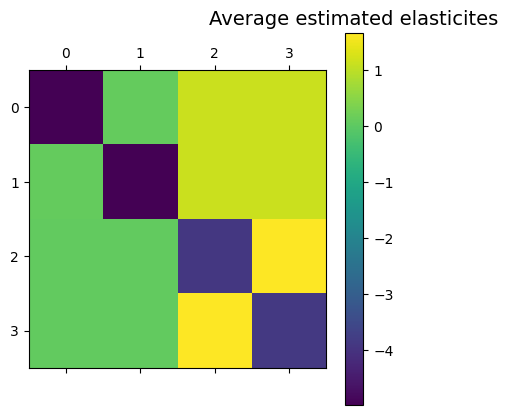

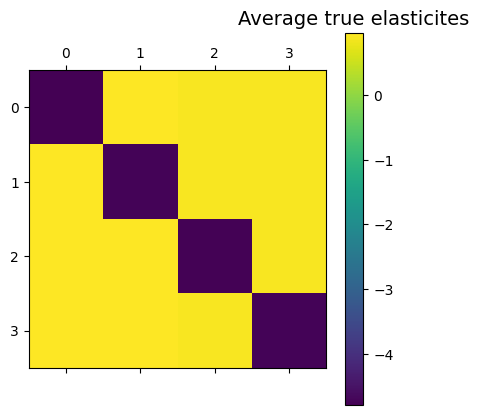

In [69]:
est_elasticities = results_c.compute_elasticities().reshape((T, J, J))
avg_est_elasticities = est_elasticities.mean(axis= 0)

def calc_derivative(share_j, share_k):
    if share_j == share_k: # dsj_dpj
        return alpha * share_j * (1 - share_j )
    else: # dsj_dpk
        return -1 * alpha * share_j *  share_k

def calc_elasticities(all_shares):
    elasticity_matrix = np.empty((T,J,J))
    for t in range(T):
        for j in range(J): # row of elasticity matrix in market t
            for k in range(J): # col of elasticity matrix in market t
                share = all_shares[t,j]
                price = equilib_prices[t,k]
                deriv = calc_derivative(all_shares[t,j], all_shares[t,k])
                elasticity_matrix[t,j,k] = deriv * (price / share)
    return elasticity_matrix

true_elasticities = calc_elasticities(observed_shares)
avg_true_elasticities = true_elasticities.mean(axis= 0)

plt1 = plt.colorbar(plt.matshow(avg_est_elasticities))
plt1.ax.set_title('Average estimated elasticites',fontsize=14)
plt2 = plt.colorbar(plt.matshow(avg_true_elasticities))
plt2.ax.set_title('Average true elasticites',fontsize=14)

Part 9 - Diversion Ratios

Computing diversion ratios with respect to prices ...
Finished after 00:00:00.



Text(0.5, 1.0, 'Average true Diversion Matrix')

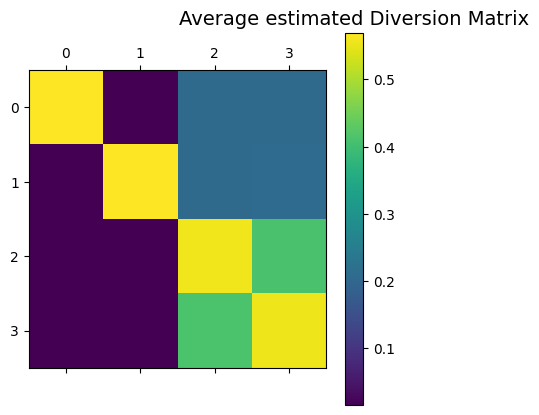

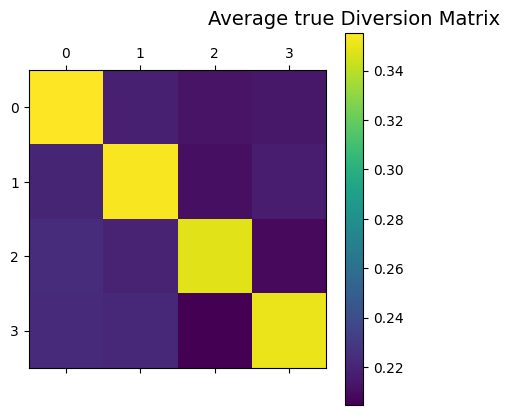

In [70]:
est_div_ratios = results_c.compute_diversion_ratios().reshape((T, J, J))
avg_est_div_ratios = est_div_ratios.mean(axis= 0)
avg_true_div_matrix = true_div_matrix.mean(axis= 0)

plt1 = plt.colorbar(plt.matshow(avg_est_div_ratios))
plt1.ax.set_title('Average estimated Diversion Matrix',fontsize=14)
plt2 = plt.colorbar(plt.matshow(avg_true_div_matrix))
plt2.ax.set_title('Average true Diversion Matrix',fontsize=14)

Part 10 - Predict post merger prices (1 and 2 merge)

In [101]:
costs = results_c.compute_costs()

inital_prices = results_c.compute_prices(costs=costs)
init_cs = results_c.compute_consumer_surpluses(inital_prices)
inital_avg_prices = inital_prices.reshape((T, J)).mean(axis=0)
init_avg_profits = results_c.compute_profits(costs=costs).reshape((T, J)).mean(axis=1)

## Merger between firms 1 and 2
product_data['merger_ids'] = product_data['firm_ids'].replace(2, 1)

## Post-merger equilibrium prices
merger_1_2_prices = results_c.compute_prices(
    firm_ids=product_data['merger_ids'],
    costs=costs
)

avg_merger_1_2_prices = merger_1_2_prices.reshape((T, J)).mean(axis=0)
for i in range(J):
    print(f'Average Predicted Merger Prices Good {i + 1}:', avg_merger_1_2_prices[i])


Computing marginal costs ...
Finished after 00:00:00.

Solving for equilibrium prices ...
Finished after 00:00:00.

Computing consumer surpluses with the equation that assumes away nonlinear income effects ...
Finished after 00:00:00.

Computing profits ...
Finished after 00:00:00.

Solving for equilibrium prices ...
Finished after 00:00:00.

Average Predicted Merger Prices Good 1: 2.5504535439055207
Average Predicted Merger Prices Good 2: 2.5542046209822757
Average Predicted Merger Prices Good 3: 2.799212324057561
Average Predicted Merger Prices Good 4: 2.78768302884056


Part 11 - Compare mergers

The code in this section prints out the predicted price change for each good in both merger scenarios. The first merger has a larger increase for goods 1 and 2 and very small increase for goods 3 and 4. This makes sense because there is now market power for satellite services. The second merger has larger overall increase of prices, especiall for good 1 and a lesser extent good 3.

In [105]:
## Merger between firms 1 and 3
product_data['merger_ids'] = product_data['firm_ids'].replace(3, 1)

## Post-merger equilibrium prices
merger_1_3_prices = results_c.compute_prices(
    firm_ids=product_data['merger_ids'],
    costs=costs
)

avg_merger_1_3_prices = merger_1_3_prices.reshape((T, J)).mean(axis=0)

merger_1_2_price_change = avg_merger_1_2_prices - inital_avg_prices
merger_1_3_price_change = avg_merger_1_3_prices - inital_avg_prices

for i in range(J):
    print(f'Average Price Change (Merger 1 and 2) Good {i + 1}:', merger_1_2_price_change[i])

print("\n")

for i in range(J):
    print(f'Average Price Change (Merger 1 and 3) Good {i + 1}:', merger_1_3_price_change[i])


Solving for equilibrium prices ...
Finished after 00:00:00.

Average Price Change (Merger 1 and 2) Good 1: 0.008945738517396329
Average Price Change (Merger 1 and 2) Good 2: 0.008823615367910875
Average Price Change (Merger 1 and 2) Good 3: 5.372168467010496e-05
Average Price Change (Merger 1 and 2) Good 4: 5.778609592566042e-05


Average Price Change (Merger 1 and 3) Good 1: 0.1743173768711732
Average Price Change (Merger 1 and 3) Good 2: 4.6473371771327265e-05
Average Price Change (Merger 1 and 3) Good 3: 0.006926257191879781
Average Price Change (Merger 1 and 3) Good 4: 0.0011062791751519363


Part 12 - Impact of Merger on Consumer Welfare

In [143]:
product_data['merger_ids'] = product_data['firm_ids'].replace(2, 1)

merger_costs= costs.copy()
merger_costs[product_data.merger_ids== 1]= 0.85*merger_costs[product_data.merger_ids== 1]

merger_cost_reduction = results_c.compute_prices(
    firm_ids=product_data['merger_ids'],
    costs=costs
)

avg_merger_cost_reductions = merger_cost_reduction.reshape((T, J)).mean(axis=0)
for i in range(J):
    print(f'Average Price Cost Reduction Merger Good {i + 1}:', avg_merger_cost_reductions[i])

print("\n")

merger_cs = results_c.compute_consumer_surpluses(merger_cost_reduction)
print("Predicted Impact on Consumer Welfare", np.average(merger_cs) - np.average(init_cs))


Solving for equilibrium prices ...
Finished after 00:00:01.

Average Price Cost Reduction Merger Good 1: 2.5504535439055207
Average Price Cost Reduction Merger Good 2: 2.5542046209822757
Average Price Cost Reduction Merger Good 3: 2.799212324057561
Average Price Cost Reduction Merger Good 4: 2.78768302884056


Computing consumer surpluses with the equation that assumes away nonlinear income effects ...
Finished after 00:00:00.

Predicted Impact on Consumer Welfare -0.0002436506542665695


Part 13 - Impact of Merger on Total Welfare

We need to assume that each market is the same size for computing welfare because that way we can weight consumer surplus changed across all markets evenly. Until now, market size was not relevant because we were calculating demand by market. Consequently, each market had its own calculated product shares and prices. 

In [110]:
merger_avg_profits = results_c.compute_profits(costs=merger_cost_reduction).reshape((T, J)).mean(axis=1)

init_welfare = init_cs + init_avg_profits
merger_welfare = merger_cs + merger_avg_profits

print("Predicted Impact on Total Welfare", np.average(merger_welfare) - np.average(init_welfare))



Computing profits ...
Finished after 00:00:00.

Predicted Impact on Total Welfare -0.11306855236831453
